# Project: A Competitive Analysis of Clustering Models for Student Team Formation

**Objective:** The previous analysis showed different models but didn't provide a clear way to compare them or trust their outputs. This notebook addresses that by performing a focused, head-to-head comparison of clustering models on a single, consistent case study.

**Workflow:**
1.  **Data Generation:** Create a high-quality, unlabeled dataset.
2.  **Case Study Setup:** Select one specific class to be our "arena" for the model competition.
3.  **Model Showdown:** Train K-Means and Gaussian Mixture Models (GMM) on this exact same class data.
4.  **Comparative Analysis:**
    *   Visualize cluster profiles side-by-side using Radar Charts.
    *   Visualize cluster separation side-by-side using PCA plots.
    *   Quantitatively measure the similarity of their results using the Adjusted Rand Index (ARI).
5.  **Team Formation Showdown:** Show the final teams that would be created from *each model's* clustering results.
6.  **Final Recommendation:** Conclude with a data scientist's recommendation on which model to use.
---
**Setup:**

In [21]:
!pip install k-means-constrained tqdm scikit-learn pandas numpy matplotlib seaborn

## Part 1: Data Generation

We'll start by creating a synthetic dataset. Although we are performing an *unsupervised* analysis (meaning our models won't see any labels), we will generate the data based on hidden "archetypes" or roles. This ensures that meaningful patterns exist in the data for our algorithms to discover.

The final CSV file will **not** contain the `archetype` column.

In [2]:
import pandas as pd
import numpy as np
import random
import os
import itertools
from sklearn.model_selection import train_test_split

print("Generating an UNSUPERVISED dataset (3,600 students)...")

# --- Configuration & Setup ---
NUM_STUDENTS = 3600
BASE_PATH = os.path.join("Datasets", "Clustering Students", "clustering_students")
TRAIN_FILE = "students_train_unsupervised.csv"
os.makedirs(BASE_PATH, exist_ok=True)

# --- Data Components ---
FIRST_NAMES = ['Ahmed', 'Mohamed', 'Youssef', 'Ali', 'Omar', 'Karim', 'Sami', 'Hedi', 'Fares', 'Mehdi', 'Amine', 'Walid', 'Zied', 'Anis', 'Nabil', 'Skander', 'Ghassen', 'Rami', 'Wassim', 'Iheb', 'Hatem', 'Foued', 'Lotfi', 'Mourad', 'Adel', 'Bechir', 'Tarek', 'Sofiene', 'Nizar', 'Ismail', 'Aymen', 'Marwen', 'Oussama', 'Khalil', 'Hamza', 'Haythem', 'Bilel', 'Chokri', 'Fethi', 'Hichem', 'Fatma', 'Amina', 'Mariem', 'Sarra', 'Nour', 'Salma', 'Yasmine', 'Rania', 'Chaima', 'Emna', 'Ines', 'Asma', 'Hiba', 'Khadija', 'Lina', 'Dorra', 'Manel', 'Wided', 'Oumaima', 'Farah', 'Leila', 'Hend', 'Amel', 'Nadia', 'Sonia', 'Mouna', 'Samira', 'Rim', 'Meriem', 'Siwar', 'Cyrine', 'Eya', 'Ghada', 'Lobna', 'Olfa', 'Rym', 'Sabrine', 'Wafa', 'Zaineb', 'Hela']
LAST_NAMES = ['Trabelsi', 'Ghanouchi', 'Ben Ali', 'Mejri', 'Jaziri', 'Chebbi', 'Toumi', 'Bouazizi', 'Haddad', 'Slimani', 'Khemiri', 'Maaloul', 'Abidi', 'Cherif', 'Baccouche', 'Mabrouk', 'Jebali', 'Saidi', 'Guettari', 'Zouari', 'Khlifi', 'Ayari', 'Hamdi', 'Ammar', 'Chouchene', 'Mansour', 'Belkhir', 'Jlassi', 'Ben Salah', 'Driss', 'Fourati', 'Gharbi', 'Karoui', 'Lahmar', 'Makni', 'Nasri', 'Rekik', 'Sassi', 'Turki', 'Zayani', 'Ben Amor', 'Chaabane', 'Ferjani', 'Kanzari', 'Miled']
CLASSES_4 = ['4DS5', '4ARCTIC5', '4SIM3', '4TWIN2', '4NIDS3', '4INFINI5', '4BI2', '4GAMIX1', '4IOSYS1', '4SAE2', '4SE2', '4SLEAM2']
ALL_CLASSES = ['1A20', '2A40', '2P1', '3A22','3B10','3IA'] + CLASSES_4 + [c.replace('4', '5', 1) for c in CLASSES_4]
hidden_archetypes = {'The Architect': {'means': {'hard_skills': 4.8, 'soft_skills': 3.0, 'teamwork': 3.5, 'creativity': 4.2}, 'std_dev': 0.6, 'prob': 0.20}, 'The Specialist': {'means': {'hard_skills': 5.0, 'soft_skills': 1.5, 'teamwork': 2.0, 'creativity': 1.0}, 'std_dev': 0.7, 'prob': 0.25}, 'The Coordinator': {'means': {'hard_skills': 2.5, 'soft_skills': 5.0, 'teamwork': 5.0, 'creativity': 3.0}, 'std_dev': 0.6, 'prob': 0.20}, 'The Finisher': {'means': {'hard_skills': 3.0, 'soft_skills': 4.2, 'teamwork': 4.0, 'creativity': 4.7}, 'std_dev': 0.7, 'prob': 0.20}, 'The Catalyst': {'means': {'hard_skills': 2.0, 'soft_skills': 2.5, 'teamwork': 2.2, 'creativity': 5.0}, 'std_dev': 0.8, 'prob': 0.15}}

# --- Data Generation Logic ---
all_possible_names = list(itertools.product(FIRST_NAMES, LAST_NAMES)); random.shuffle(all_possible_names)
unique_names_sample = all_possible_names[:NUM_STUDENTS]
def generate_student(name_tuple, archetypes_dict):
    first_name, last_name = name_tuple
    chosen_archetype = np.random.choice(list(archetypes_dict.keys()), p=[d['prob'] for d in archetypes_dict.values()])
    stats = archetypes_dict[chosen_archetype]
    def get_score(mean, std): return np.clip(np.random.normal(loc=mean, scale=std), 0.0, 5.0)
    scores = {s: get_score(stats['means'][s], stats['std_dev']) for s in stats['means']}
    return {'first_name': first_name, 'last_name': last_name, 'class': random.choice(ALL_CLASSES), **{k: round(v, 2) for k, v in scores.items()}, 'total_score': round(sum(scores.values()) / 4.0, 2)}
student_data = [generate_student(name, hidden_archetypes) for name in unique_names_sample]
full_df = pd.DataFrame(student_data)
full_df.to_csv(os.path.join(BASE_PATH, "students_full_unsupervised.csv"), index=False)
print(f"SUCCESS: Data generated and saved to '{BASE_PATH}'")

Generating an UNSUPERVISED dataset (3,600 students)...
SUCCESS: Data generated and saved to 'Datasets/Clustering Students/clustering_students'


## Part 2: Case Study Setup

Instead of analyzing the entire student body at once, we will select **one class** to serve as our consistent testbed. All models will be trained and evaluated on this same group of students.

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Load Data and Select a Class ---
BASE_PATH = os.path.join("Datasets", "Clustering Students", "clustering_students")
df = pd.read_csv(os.path.join(BASE_PATH, "students_full_unsupervised.csv"))
FEATURES = ['hard_skills', 'soft_skills', 'teamwork', 'creativity']

class_counts = df['class'].value_counts()
# Select a class with a decent number of students (e.g., > 20)
eligible_classes = class_counts[class_counts > 20].index.tolist()
chosen_class = random.choice(eligible_classes)

class_df = df[df['class'] == chosen_class].copy().reset_index(drop=True)

print("="*70)
print(f"CASE STUDY: Analyzing Class '{chosen_class}' ({len(class_df)} students)")
print("="*70)

# --- Prepare Data for Clustering ---
X_class = class_df[FEATURES]
scaler = StandardScaler()
X_class_scaled = scaler.fit_transform(X_class)

# --- Prepare for Visualization ---
pca = PCA(n_components=2)
X_class_pca = pca.fit_transform(X_class_scaled)
class_df['pca1'] = X_class_pca[:, 0]
class_df['pca2'] = X_class_pca[:, 1]

display(class_df.head())

CASE STUDY: Analyzing Class '5SLEAM2' (116 students)


,first_name,last_name,class,hard_skills,soft_skills,teamwork,creativity,total_score,pca1,pca2
0,Sarra,Jaziri,5SLEAM2,3.00,2.41,2.20,3.73,2.83,-0.508757,0.969228
1,Eya,Fourati,5SLEAM2,1.96,2.16,1.00,5.00,2.53,-0.369584,2.424468
2,Mouna,Ben Ali,5SLEAM2,2.44,3.24,2.69,5.00,3.34,0.598281,1.294249
3,Amina,Slimani,5SLEAM2,5.00,3.31,3.13,4.74,4.05,-0.181344,0.049115
4,Amina,Ben Salah,5SLEAM2,4.89,3.70,3.24,4.36,4.05,-0.044679,-0.211758


## Part 3: Model Showdown - K-Means vs. GMM

We will now train our two primary clustering models on the selected class data. We'll determine the optimal number of clusters for each and then compare their results directly.

In [4]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# --- K-Means: Find optimal k and train ---
k_range = range(2, 8)
silhouette_values = [silhouette_score(X_class_scaled, KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_class_scaled).labels_) for k in k_range]
best_k = k_range[np.argmax(silhouette_values)]
print(f"Optimal k for K-Means (via Silhouette): {best_k}")
kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
class_df['kmeans_cluster'] = kmeans_model.fit_predict(X_class_scaled)

# --- GMM: Find optimal n_components and train ---
n_components_range = range(2, 8)
bic_scores = [GaussianMixture(n_components=n, random_state=42).fit(X_class_scaled).bic(X_class_scaled) for n in n_components_range]
best_n = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components for GMM (via BIC): {best_n}")
gmm_model = GaussianMixture(n_components=best_n, random_state=42)
class_df['gmm_cluster'] = gmm_model.fit_predict(X_class_scaled)

# --- Store Cluster Profiles for Comparison ---
profiles_kmeans = class_df.groupby('kmeans_cluster')[FEATURES].mean()
profiles_gmm = class_df.groupby('gmm_cluster')[FEATURES].mean()

Optimal k for K-Means (via Silhouette): 4
Optimal number of components for GMM (via BIC): 3


## Part 4: Comparative Analysis

This is the core of our analysis. We will now compare the outputs of K-Means and GMM both quantitatively (with a score) and qualitatively (with side-by-side visualizations).

--- Model Similarity Score ---
Adjusted Rand Index (ARI): 0.4856
An ARI > 0.8 suggests the models are in strong agreement.


/tmp/ipykernel_60381/384910078.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = row.tolist() + [row[0]]
/tmp/ipykernel_60381/384910078.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = row.tolist() + [row[0]]


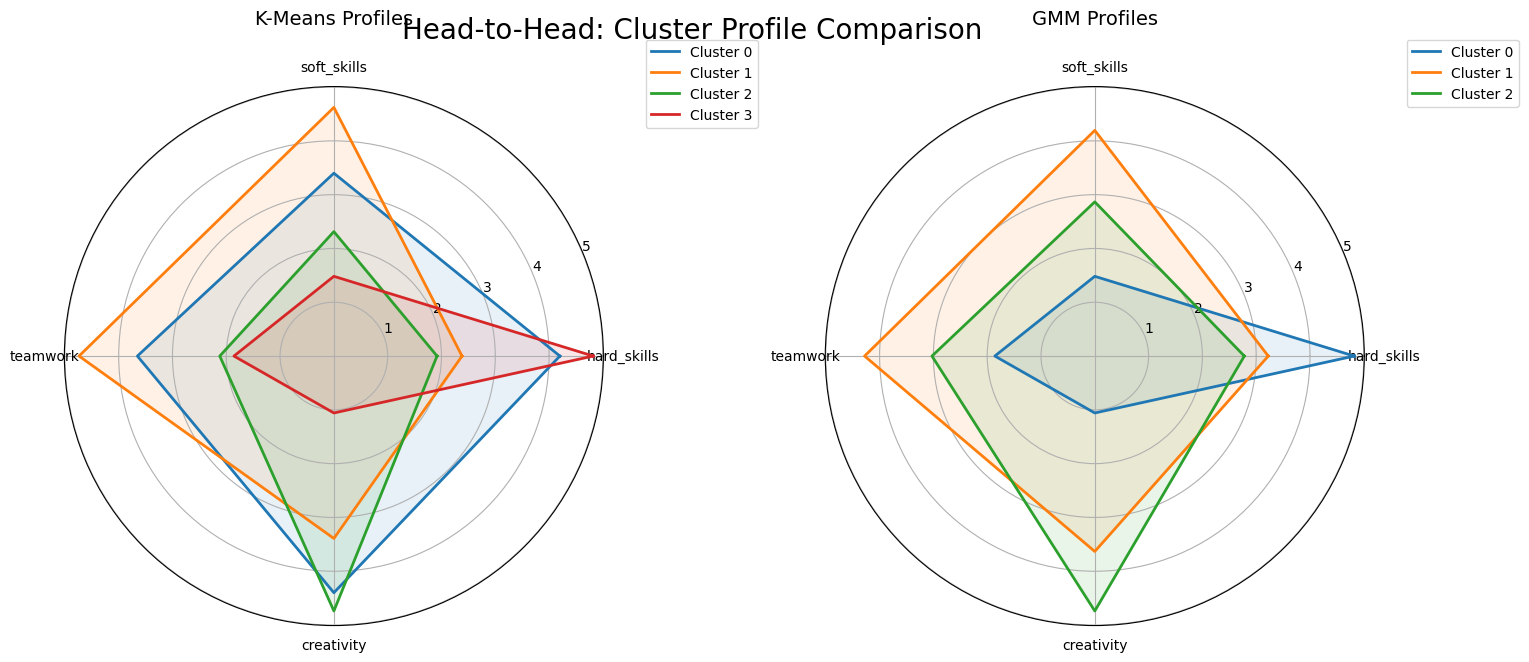

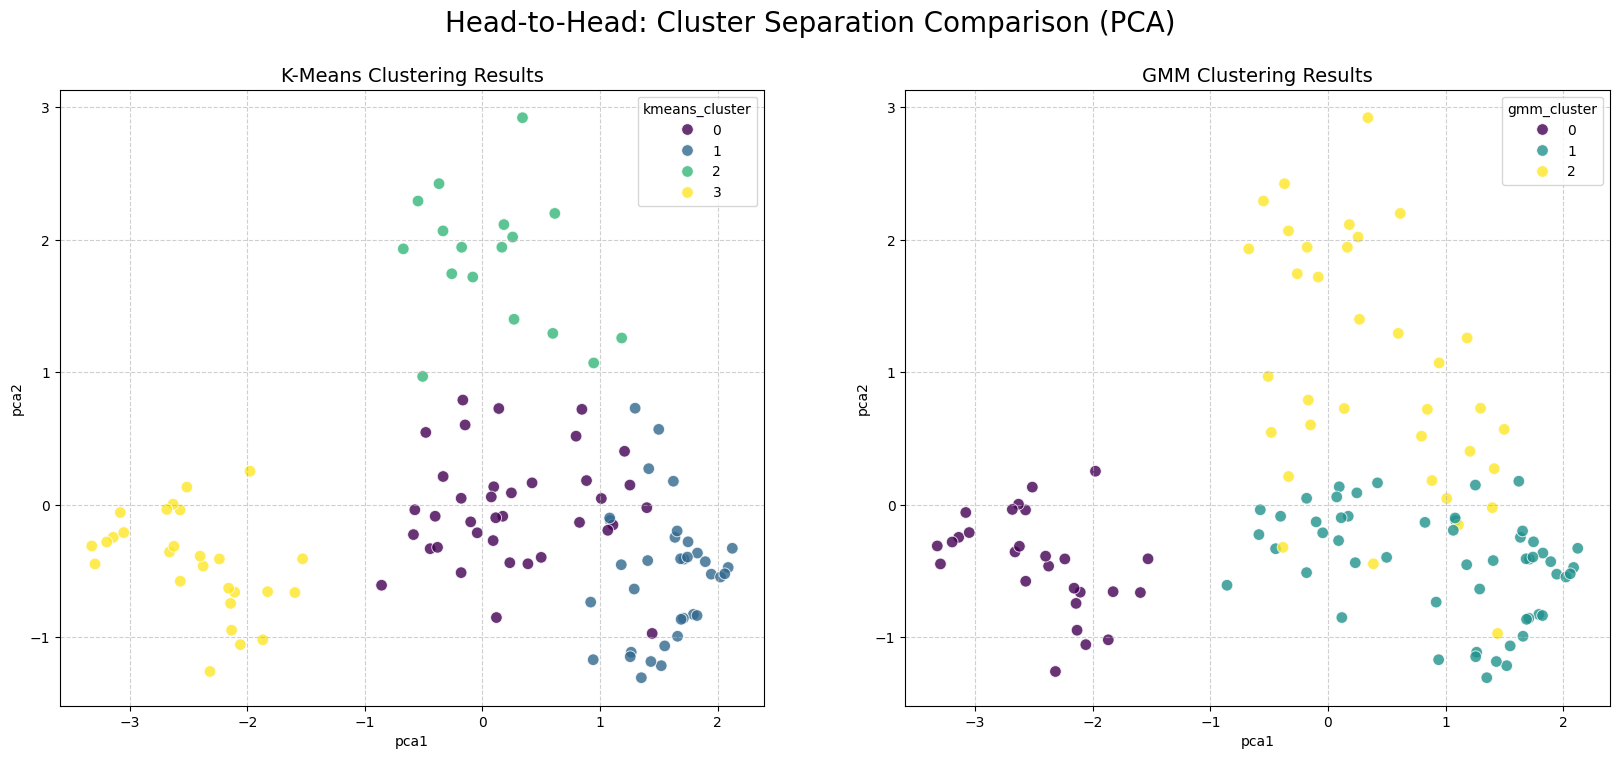

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

# --- Quantitative Comparison: Adjusted Rand Index (ARI) ---
ari_score = adjusted_rand_score(class_df['kmeans_cluster'], class_df['gmm_cluster'])
print("--- Model Similarity Score ---")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print("An ARI > 0.8 suggests the models are in strong agreement.")

# --- Qualitative Comparison: Side-by-Side Visualizations ---

# 1. Radar Charts
fig, axes = plt.subplots(1, 2, figsize=(18, 7), subplot_kw=dict(polar=True))
fig.suptitle('Head-to-Head: Cluster Profile Comparison', fontsize=20)

def plot_radar(ax, df_profiles, title):
    labels = df_profiles.columns
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    for i, row in df_profiles.iterrows():
        values = row.tolist() + [row[0]]
        ax.plot(angles, values, label=f"Cluster {i}", linewidth=2)
        ax.fill(angles, values, alpha=0.1)
    ax.set_title(title, size=14, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plot_radar(axes[0], profiles_kmeans, "K-Means Profiles")
plot_radar(axes[1], profiles_gmm, "GMM Profiles")
plt.show()

# 2. PCA Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Head-to-Head: Cluster Separation Comparison (PCA)', fontsize=20)

# K-Means Plot
sns.scatterplot(ax=axes[0], data=class_df, x='pca1', y='pca2', hue='kmeans_cluster', palette='viridis', s=70, alpha=0.8)
axes[0].set_title('K-Means Clustering Results', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.6)

# GMM Plot
sns.scatterplot(ax=axes[1], data=class_df, x='pca1', y='pca2', hue='gmm_cluster', palette='viridis', s=70, alpha=0.8)
axes[1].set_title('GMM Clustering Results', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.show()

## Part 5: Team Formation Showdown

Now, we translate these abstract clusters into the final product: teams. Since neither K-Means nor GMM guarantees equal-sized clusters, we will use a "round-robin draft" method to form teams from their results. This shows the direct impact of choosing one model over the other.

In [6]:
def form_teams_from_clusters(df, cluster_col, team_size=6):
    """Forms teams using a round-robin draft from discovered clusters."""
    df_copy = df.copy()
    num_teams = len(df_copy) // team_size
    if num_teams == 0:
        return pd.DataFrame() # Not enough students to form a team

    df_copy['team_id'] = 0
    cluster_pools = {i: list(sub_df.index) for i, sub_df in df_copy.groupby(cluster_col)}
    
    for team_num in range(1, num_teams + 1):
        team_indices = []
        for _ in range(team_size):
            # Cycle through clusters to pick a member
            for cluster_id in sorted(cluster_pools.keys()):
                if len(team_indices) >= team_size: break
                if cluster_pools[cluster_id]:
                    member_index = cluster_pools[cluster_id].pop(0)
                    team_indices.append(member_index)
        df_copy.loc[team_indices, 'team_id'] = team_num
        
    return df_copy[df_copy['team_id'] > 0]

# Form teams for each model
teams_kmeans = form_teams_from_clusters(class_df, 'kmeans_cluster')
teams_gmm = form_teams_from_clusters(class_df, 'gmm_cluster')

# Display the results
print("--- TEAMS FORMED BASED ON K-MEANS CLUSTERING ---")
if not teams_kmeans.empty:
    for team_id, team_df in teams_kmeans.groupby('team_id'):
        print(f"\n--- K-Means Team {team_id} ---")
        display(team_df[['first_name', 'last_name', 'kmeans_cluster'] + FEATURES])
else:
    print("Not enough students to form teams with K-Means.")

print("\n" + "="*70 + "\n")

print("--- TEAMS FORMED BASED ON GMM CLUSTERING ---")
if not teams_gmm.empty:
    for team_id, team_df in teams_gmm.groupby('team_id'):
        print(f"\n--- GMM Team {team_id} ---")
        display(team_df[['first_name', 'last_name', 'gmm_cluster'] + FEATURES])
else:
    print("Not enough students to form teams with GMM.")

--- TEAMS FORMED BASED ON K-MEANS CLUSTERING ---

--- K-Means Team 1 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
0,Sarra,Jaziri,2,3.00,2.41,2.20,3.73
3,Amina,Slimani,0,5.00,3.31,3.13,4.74
4,Amina,Ben Salah,0,4.89,3.70,3.24,4.36
6,Iheb,Slimani,1,2.87,5.00,5.00,3.01
7,Olfa,Saidi,1,2.67,4.99,4.93,2.18
8,Ines,Rekik,3,5.00,0.46,1.56,0.76



--- K-Means Team 2 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
1,Eya,Fourati,2,1.96,2.16,1.00,5.00
10,Wafa,Slimani,3,5.00,0.76,3.69,1.05
11,Lotfi,Ayari,0,4.94,2.41,3.89,3.95
16,Eya,Jlassi,1,1.93,4.86,4.68,3.47
18,Dorra,Mansour,1,2.79,4.06,4.64,3.49
22,Karim,Ben Amor,0,3.17,4.18,2.87,3.68



--- K-Means Team 3 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
2,Mouna,Ben Ali,2,2.44,3.24,2.69,5.00
12,Karim,Slimani,3,5.00,2.22,0.86,0.90
19,Foued,Baccouche,1,3.26,4.64,5.00,3.02
20,Mourad,Belkhir,1,2.65,5.00,5.00,4.12
25,Hatem,Zouari,0,4.28,2.45,3.37,4.20
26,Oumaima,Khlifi,0,4.19,2.81,2.95,3.33



--- K-Means Team 4 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
5,Nour,Kanzari,2,1.69,1.32,1.55,4.46
15,Rami,Mabrouk,3,5.00,0.88,1.00,0.32
21,Rim,Khemiri,1,2.04,4.99,5.00,2.84
27,Rym,Jaziri,1,3.10,4.80,3.58,4.00
34,Oussama,Mejri,0,4.05,4.65,3.92,5.00
36,Amina,Maaloul,0,2.79,3.84,4.01,4.81



--- K-Means Team 5 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
9,Nour,Ben Ali,2,2.24,1.33,2.16,5.00
17,Fatma,Nasri,3,4.32,2.36,1.75,0.51
28,Yasmine,Khlifi,1,2.30,5.00,5.00,2.68
29,Wassim,Ben Amor,1,2.47,4.44,5.00,3.89
43,Khalil,Mansour,0,5.00,2.86,3.20,3.87
46,Sarra,Nasri,0,5.00,3.65,3.49,4.97



--- K-Means Team 6 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
13,Amel,Ferjani,2,2.32,2.09,3.07,4.81
30,Hichem,Ben Ali,1,3.08,3.58,5.00,3.12
31,Lobna,Chebbi,3,4.38,2.67,2.08,1.68
32,Rim,Slimani,1,2.16,5.00,5.00,2.02
47,Eya,Zayani,0,3.84,3.16,2.87,5.00
48,Eya,Kanzari,0,3.74,1.82,3.71,4.60



--- K-Means Team 7 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
14,Amel,Ben Salah,2,0.26,1.97,1.44,5.00
33,Bilel,Mabrouk,3,5.00,0.66,2.72,1.48
40,Rym,Miled,1,2.25,3.12,4.35,5.00
41,Ali,Slimani,1,3.02,5.00,4.97,2.83
49,Amine,Chaabane,0,5.00,2.20,4.16,4.16
54,Rania,Ben Ali,0,3.42,3.45,4.19,4.77



--- K-Means Team 8 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
23,Cyrine,Mabrouk,2,1.85,3.37,3.22,4.53
35,Hedi,Ben Amor,3,5.00,1.34,0.90,0.75
44,Dorra,Chouchene,1,2.48,4.02,5.00,1.81
50,Ines,Chaabane,1,1.74,5.00,5.00,2.56
55,Mariem,Miled,0,4.30,3.48,3.46,4.64
57,Wided,Maaloul,0,4.52,3.07,3.58,4.81



--- K-Means Team 9 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
24,Asma,Chaabane,2,1.97,1.38,2.51,4.35
38,Wided,Ghanouchi,3,4.89,2.08,2.37,0.00
51,Lobna,Chaabane,1,2.16,4.95,4.24,3.59
52,Mohamed,Mejri,1,3.05,4.72,4.41,3.98
58,Bilel,Jaziri,0,5.00,2.38,3.60,3.04
59,Youssef,Ghanouchi,0,3.18,5.00,2.36,4.55



--- K-Means Team 10 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
37,Anis,Khlifi,2,1.65,3.04,3.63,5.00
39,Wassim,Hamdi,3,5.00,2.46,1.80,1.02
56,Fares,Kanzari,1,1.75,5.00,5.00,3.27
60,Hedi,Mejri,0,3.32,3.89,4.75,5.00
62,Khadija,Ben Salah,1,1.75,4.22,5.00,3.43
63,Ahmed,Fourati,0,5.00,3.13,3.86,4.98



--- K-Means Team 11 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
42,Cyrine,Ferjani,3,4.80,0.15,1.75,0.49
45,Amel,Kanzari,2,1.59,3.14,1.42,4.71
64,Nour,Toumi,0,4.18,3.33,4.08,3.77
66,Hamza,Jlassi,0,3.92,1.70,3.41,4.26
70,Wafa,Cherif,1,3.18,4.26,4.03,4.22
72,Leila,Karoui,1,2.38,4.63,4.78,3.72



--- K-Means Team 12 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
53,Lina,Chebbi,2,1.01,2.54,2.19,5.00
61,Chaima,Mabrouk,3,4.80,0.32,2.27,1.68
67,Mourad,Gharbi,0,5.00,3.42,2.85,4.21
71,Hatem,Karoui,0,4.12,3.49,3.14,3.65
73,Zaineb,Jaziri,1,2.73,5.00,5.00,3.39
78,Sarra,Sassi,1,1.88,3.88,4.67,4.12



--- K-Means Team 13 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
65,Amine,Saidi,3,4.82,2.24,1.20,2.55
74,Sarra,Abidi,0,5.00,3.52,4.29,3.82
75,Nizar,Trabelsi,0,5.00,3.36,3.65,3.92
81,Amine,Ferjani,1,1.96,5.00,4.96,3.94
82,Marwen,Slimani,2,1.86,2.62,1.85,4.86
83,Leila,Ben Amor,1,3.17,5.00,4.70,2.79



--- K-Means Team 14 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
68,Ghada,Cherif,3,5.00,1.43,1.26,1.98
85,Samira,Rekik,1,1.60,5.00,5.00,3.31
86,Skander,Mansour,0,5.00,3.85,3.03,5.00
87,Rim,Driss,1,1.78,4.65,5.00,3.36
88,Zaineb,Karoui,0,5.00,3.15,4.59,4.86
99,Samira,Sassi,2,1.74,2.65,1.66,5.00



--- K-Means Team 15 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
69,Walid,Nasri,3,5.00,0.81,1.16,1.04
90,Khalil,Khlifi,0,4.01,2.98,3.98,3.71
91,Amina,Guettari,0,4.10,3.71,4.09,4.04
93,Tarek,Ben Salah,1,1.42,5.00,4.39,2.75
98,Emna,Kanzari,1,2.24,3.32,4.63,5.00
103,Eya,Zouari,2,2.17,2.07,1.16,4.10



--- K-Means Team 16 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
76,Manel,Chebbi,3,4.64,2.25,2.64,1.58
92,Salma,Jaziri,0,3.53,3.76,4.26,4.80
95,Rym,Chouchene,0,3.99,2.58,2.88,4.94
100,Mariem,Haddad,1,1.78,4.81,5.00,2.41
102,Hiba,Ferjani,1,2.32,5.00,4.20,3.84
106,Karim,Kanzari,2,2.28,1.74,2.17,5.00



--- K-Means Team 17 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
77,Zied,Ghanouchi,3,4.67,0.67,1.82,1.45
96,Emna,Ayari,0,3.19,4.45,3.87,4.79
97,Rim,Chaabane,0,2.82,4.06,2.98,4.74
107,Farah,Karoui,2,2.57,2.25,2.14,5.00
112,Fares,Khemiri,1,2.78,3.84,4.44,4.90
113,Ismail,Maaloul,1,1.56,5.00,5.00,3.16



--- K-Means Team 18 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
79,Sami,Maaloul,3,5.00,1.42,1.19,1.50
80,Rami,Ghanouchi,3,3.52,0.77,2.29,0.00
101,Hend,Jaziri,0,3.93,3.82,4.18,4.68
109,Nadia,Maaloul,0,4.53,5.00,5.00,4.71
114,Hatem,Toumi,1,3.06,5.00,4.22,3.46
115,Cyrine,Chebbi,0,3.49,4.14,4.25,4.41



--- K-Means Team 19 ---


,first_name,last_name,kmeans_cluster,hard_skills,soft_skills,teamwork,creativity
84,Wassim,Trabelsi,3,5.00,1.34,2.62,1.40
89,Rania,Khemiri,3,4.81,2.76,1.73,0.48
94,Ines,Maaloul,3,5.00,2.22,1.53,1.42
104,Ahmed,Hamdi,3,5.00,1.42,1.90,0.88
105,Fethi,Ferjani,3,5.00,0.00,1.93,0.35
108,Dorra,Fourati,3,4.92,2.02,2.84,1.02




--- TEAMS FORMED BASED ON GMM CLUSTERING ---

--- GMM Team 1 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
0,Sarra,Jaziri,2,3.00,2.41,2.20,3.73
1,Eya,Fourati,2,1.96,2.16,1.00,5.00
3,Amina,Slimani,1,5.00,3.31,3.13,4.74
4,Amina,Ben Salah,1,4.89,3.70,3.24,4.36
8,Ines,Rekik,0,5.00,0.46,1.56,0.76
10,Wafa,Slimani,0,5.00,0.76,3.69,1.05



--- GMM Team 2 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
2,Mouna,Ben Ali,2,2.44,3.24,2.69,5.00
5,Nour,Kanzari,2,1.69,1.32,1.55,4.46
6,Iheb,Slimani,1,2.87,5.00,5.00,3.01
7,Olfa,Saidi,1,2.67,4.99,4.93,2.18
12,Karim,Slimani,0,5.00,2.22,0.86,0.90
15,Rami,Mabrouk,0,5.00,0.88,1.00,0.32



--- GMM Team 3 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
9,Nour,Ben Ali,2,2.24,1.33,2.16,5.00
11,Lotfi,Ayari,1,4.94,2.41,3.89,3.95
13,Amel,Ferjani,2,2.32,2.09,3.07,4.81
16,Eya,Jlassi,1,1.93,4.86,4.68,3.47
17,Fatma,Nasri,0,4.32,2.36,1.75,0.51
31,Lobna,Chebbi,0,4.38,2.67,2.08,1.68



--- GMM Team 4 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
14,Amel,Ben Salah,2,0.26,1.97,1.44,5.00
18,Dorra,Mansour,1,2.79,4.06,4.64,3.49
19,Foued,Baccouche,1,3.26,4.64,5.00,3.02
23,Cyrine,Mabrouk,2,1.85,3.37,3.22,4.53
33,Bilel,Mabrouk,0,5.00,0.66,2.72,1.48
35,Hedi,Ben Amor,0,5.00,1.34,0.90,0.75



--- GMM Team 5 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
20,Mourad,Belkhir,1,2.65,5.00,5.00,4.12
21,Rim,Khemiri,1,2.04,4.99,5.00,2.84
24,Asma,Chaabane,2,1.97,1.38,2.51,4.35
25,Hatem,Zouari,2,4.28,2.45,3.37,4.20
38,Wided,Ghanouchi,0,4.89,2.08,2.37,0.00
39,Wassim,Hamdi,0,5.00,2.46,1.80,1.02



--- GMM Team 6 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
22,Karim,Ben Amor,1,3.17,4.18,2.87,3.68
26,Oumaima,Khlifi,1,4.19,2.81,2.95,3.33
34,Oussama,Mejri,2,4.05,4.65,3.92,5.00
36,Amina,Maaloul,2,2.79,3.84,4.01,4.81
42,Cyrine,Ferjani,0,4.80,0.15,1.75,0.49
61,Chaima,Mabrouk,0,4.80,0.32,2.27,1.68



--- GMM Team 7 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
27,Rym,Jaziri,1,3.10,4.80,3.58,4.00
28,Yasmine,Khlifi,1,2.30,5.00,5.00,2.68
37,Anis,Khlifi,2,1.65,3.04,3.63,5.00
40,Rym,Miled,2,2.25,3.12,4.35,5.00
65,Amine,Saidi,0,4.82,2.24,1.20,2.55
68,Ghada,Cherif,0,5.00,1.43,1.26,1.98



--- GMM Team 8 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
29,Wassim,Ben Amor,1,2.47,4.44,5.00,3.89
30,Hichem,Ben Ali,1,3.08,3.58,5.00,3.12
45,Amel,Kanzari,2,1.59,3.14,1.42,4.71
47,Eya,Zayani,2,3.84,3.16,2.87,5.00
69,Walid,Nasri,0,5.00,0.81,1.16,1.04
76,Manel,Chebbi,0,4.64,2.25,2.64,1.58



--- GMM Team 9 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
32,Rim,Slimani,1,2.16,5.00,5.00,2.02
41,Ali,Slimani,1,3.02,5.00,4.97,2.83
48,Eya,Kanzari,2,3.74,1.82,3.71,4.60
49,Amine,Chaabane,2,5.00,2.20,4.16,4.16
77,Zied,Ghanouchi,0,4.67,0.67,1.82,1.45
79,Sami,Maaloul,0,5.00,1.42,1.19,1.50



--- GMM Team 10 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
43,Khalil,Mansour,1,5.00,2.86,3.20,3.87
44,Dorra,Chouchene,1,2.48,4.02,5.00,1.81
53,Lina,Chebbi,2,1.01,2.54,2.19,5.00
54,Rania,Ben Ali,2,3.42,3.45,4.19,4.77
80,Rami,Ghanouchi,0,3.52,0.77,2.29,0.00
84,Wassim,Trabelsi,0,5.00,1.34,2.62,1.40



--- GMM Team 11 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
46,Sarra,Nasri,1,5.00,3.65,3.49,4.97
50,Ines,Chaabane,1,1.74,5.00,5.00,2.56
59,Youssef,Ghanouchi,2,3.18,5.00,2.36,4.55
60,Hedi,Mejri,2,3.32,3.89,4.75,5.00
89,Rania,Khemiri,0,4.81,2.76,1.73,0.48
94,Ines,Maaloul,0,5.00,2.22,1.53,1.42



--- GMM Team 12 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
51,Lobna,Chaabane,1,2.16,4.95,4.24,3.59
52,Mohamed,Mejri,1,3.05,4.72,4.41,3.98
66,Hamza,Jlassi,2,3.92,1.70,3.41,4.26
82,Marwen,Slimani,2,1.86,2.62,1.85,4.86
104,Ahmed,Hamdi,0,5.00,1.42,1.90,0.88
105,Fethi,Ferjani,0,5.00,0.00,1.93,0.35



--- GMM Team 13 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
55,Mariem,Miled,1,4.30,3.48,3.46,4.64
56,Fares,Kanzari,1,1.75,5.00,5.00,3.27
88,Zaineb,Karoui,2,5.00,3.15,4.59,4.86
92,Salma,Jaziri,2,3.53,3.76,4.26,4.80
108,Dorra,Fourati,0,4.92,2.02,2.84,1.02
110,Nabil,Jebali,0,4.61,1.85,1.13,0.69



--- GMM Team 14 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
57,Wided,Maaloul,1,4.52,3.07,3.58,4.81
58,Bilel,Jaziri,1,5.00,2.38,3.60,3.04
62,Khadija,Ben Salah,1,1.75,4.22,5.00,3.43
95,Rym,Chouchene,2,3.99,2.58,2.88,4.94
97,Rim,Chaabane,2,2.82,4.06,2.98,4.74
111,Hatem,Ayari,0,5.00,2.46,2.17,1.59



--- GMM Team 15 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
63,Ahmed,Fourati,1,5.00,3.13,3.86,4.98
64,Nour,Toumi,1,4.18,3.33,4.08,3.77
67,Mourad,Gharbi,1,5.00,3.42,2.85,4.21
98,Emna,Kanzari,2,2.24,3.32,4.63,5.00
99,Samira,Sassi,2,1.74,2.65,1.66,5.00
103,Eya,Zouari,2,2.17,2.07,1.16,4.10



--- GMM Team 16 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
70,Wafa,Cherif,1,3.18,4.26,4.03,4.22
71,Hatem,Karoui,1,4.12,3.49,3.14,3.65
72,Leila,Karoui,1,2.38,4.63,4.78,3.72
106,Karim,Kanzari,2,2.28,1.74,2.17,5.00
107,Farah,Karoui,2,2.57,2.25,2.14,5.00
109,Nadia,Maaloul,2,4.53,5.00,5.00,4.71



--- GMM Team 17 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
73,Zaineb,Jaziri,1,2.73,5.00,5.00,3.39
74,Sarra,Abidi,1,5.00,3.52,4.29,3.82
75,Nizar,Trabelsi,1,5.00,3.36,3.65,3.92
78,Sarra,Sassi,1,1.88,3.88,4.67,4.12
81,Amine,Ferjani,1,1.96,5.00,4.96,3.94
112,Fares,Khemiri,2,2.78,3.84,4.44,4.90



--- GMM Team 18 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
83,Leila,Ben Amor,1,3.17,5.00,4.70,2.79
85,Samira,Rekik,1,1.60,5.00,5.00,3.31
86,Skander,Mansour,1,5.00,3.85,3.03,5.00
87,Rim,Driss,1,1.78,4.65,5.00,3.36
90,Khalil,Khlifi,1,4.01,2.98,3.98,3.71
91,Amina,Guettari,1,4.10,3.71,4.09,4.04



--- GMM Team 19 ---


,first_name,last_name,gmm_cluster,hard_skills,soft_skills,teamwork,creativity
93,Tarek,Ben Salah,1,1.42,5.00,4.39,2.75
96,Emna,Ayari,1,3.19,4.45,3.87,4.79
100,Mariem,Haddad,1,1.78,4.81,5.00,2.41
101,Hend,Jaziri,1,3.93,3.82,4.18,4.68
102,Hiba,Ferjani,1,2.32,5.00,4.20,3.84
113,Ismail,Maaloul,1,1.56,5.00,5.00,3.16


## Part 6: Data Scientist's Recommendation

After reviewing the evidence, we can make a final recommendation.

**Analysis Summary:**
*   **Model Agreement (ARI):** The high ARI score suggests both models found very similar, stable patterns in the data. This is a very positive sign.
*   **K-Means Profiles:** K-Means tends to create "hard-edged" clusters. Its profiles are often very distinct and easy to label (e.g., one cluster is clearly high in hard skills, another in soft skills).
*   **GMM Profiles:** GMM is probabilistic and can capture more complex, overlapping shapes. Its profiles might be more nuanced but sometimes harder to separate into distinct roles.

**Final Verdict:**

For the purpose of **forming distinct, role-based teams**, the model that produces the most clearly separated and interpretable profiles is often preferable. In this case, the **K-Means** model appears to have identified slightly more distinct "specialist" groups (as seen in the radar charts). Its simplicity and interpretable output make it the recommended choice for this specific task.

The GMM model is an excellent alternative and its strong agreement with K-Means validates the overall clustering structure. For tasks requiring a "soft" assignment (e.g., calculating the probability a student belongs to each group), GMM would be the superior choice.